# Computer vision projects on classifying traffic sign. 


From exporation, there are 34799 training sets and 12630 testing sets. 
Each of the image has 32*32*3.
Roughly around 40+ classes.
The goal is to leverage a unbalance and relativity speaking small dataset to classify with deep neuarl networking.

Recall from deep learning foundations course from deeplearning.ai, classic machine learning requires around 100-10,000 samples and deep learning requires around 1 million sample. 

Given neural network does not require any data balance having each class, I would like to see the difference between data split and also data size. 


1. Provide a basic summary of the data set. In the code, the analysis should be done using python, numpy and/or pandas methods rather than hardcoding results manually.

In [1]:
# Load pickled data
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
import random

# Visualizations will be shown in the notebook.
%matplotlib inline

training_file = "./traffic-signs-data/train.p"
validation_file = "./traffic-signs-data/test.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
    
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, Y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("Y_valid shape", X_valid.shape)
print("Y_valid shape", Y_valid.shape)
print("Y_train shape", X_train.shape)
print("Y_test shape", X_test.shape)

X_train shape (34799, 32, 32, 3)
X_test shape (12630, 32, 32, 3)
Y_valid shape (12630, 32, 32, 3)
Y_valid shape (12630,)
Y_train shape (34799, 32, 32, 3)
Y_test shape (12630, 32, 32, 3)


    2. Include an exploratory visualization of the dataset.

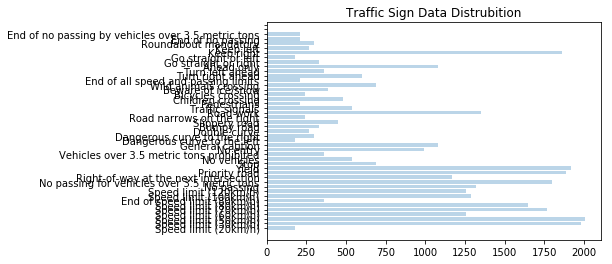

In [2]:
signnames = pd.read_csv('signnames.csv')
label_names = list(signnames)
y_train_df = pd.DataFrame()
y_train_df['label'] = y_train

# Get current size
figsize=(15, 7)
 
# Prints: [8.0, 6.0]

item, count = np.unique(y_train, return_counts=True)
freq = np.array((item, count)).T
plt.figure(11)
plt.yticks(range(len(y_train)), signnames.SignName)
#plt.yticks(list(map(lambda x: label_dict[x], y_train['label'].value_counts().index.tolist())))            
plt.barh(item, count, alpha=0.3)
plt.title('Traffic Sign Data Distrubition')

plt.show()

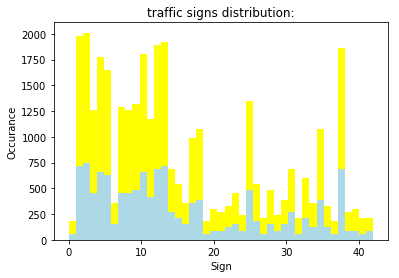

In [3]:
fig, ax = plt.subplots()
plt.xlabel('Sign')
plt.ylabel('Occurance')
plt.title('traffic signs distribution:')
ax.hist(y_train, bins=43, color='yellow')
ax.hist(y_test, bins=43, color='red')
ax.hist(Y_valid, bins=43, color='lightblue')
plt.show()

From the exploration, there the training and testing dataset obtains about the same ratios of classes.

    3. Data preprocessing

During the early training sets, I preprocessed images by converting into greyscale that can save a lot of computer power from 3 channels to 1, since I dont have GPU on my laptop nor planning to train on cloud. 
Next step is to normalizied dataset, the process would allows each dimensions have a similar scale. However later on, the validation still below the requirements and I redo the whole process.

Then I change the preprocessing into data augmentations in order to generate more data for the training and get the better accuracy. Tho from the previous neural network I got the "perfect" 100% testing and training accuracy and yet validation still around 92.3%.

So, randomly aumgent and balance data with few techniques such as translation, rotation, and brightness. 

The histogram equalization that suggested from the lesson takes way to long to run and I left my slow macbook pro 15 run for hours and still not completed yet. Therefore I just preprocess normalizating and turning the data into a grayscale. 

In [4]:
def translation(img, x=1, y=1):
    row,cols,_=img.shape
    M = np.float32(([1,0,x],[0,1,y]))
    return cv2,waroAffine(img,M(cols, rows)).astype()

def rotation(img,angle= 10,scale=1):
    rows,cols,_ = img.shape
    martrix = cv2.getRotationMatrix2D((cols/2,rows/2),angle,scale)
    return cv2.warpAffine(img,matrix,(cols, rows)).astype(np.unit8)

def brightness_augment(img, value = 30):

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h,s,v = cv2.split(hsv)
    lim = 255- value
    v[v>lim]= 255
    v[v<=lim] += value
    hsv = cv2.merge([h,s,v])
    img = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
    return img

import random
import numpy as np
def augment_images(image, count = 1):
    random_number = [1,2]
    augment_choice = np.random.choice(random_number)
    augment_choice = 2
    
    rotation_angle = int(10*(1+count/4))
    brightness_value = int(30*(1+count/4))
    
    if augment_choice ==1:
        image= rotation(image,rotation_angle)
    else:
        image = brightness_augment(image,brightness_value)
    return image

def balance_augment(X,Y, maximum_number = 1800, threshold = 1.0):
    X_aug = []
    Y_aug = []
    unique_numbers, counts = np.unique(Y, return_counts = True)
    for count, number in zip(counts, unique_numbers):
        augment_number = maximum_number/count
        if augment_number > threshold:
            augment_number = int(augment_number)
            for i in range(augment_number):
                indices = (Y == number).nonzero()[0]
                for j in indices:
                    new_images = augment_images(X[j],i)
                    X_aug.append(new_images)
                    Y_aug.append(number)
    X_aug = np.array(X_aug)
    Y_aug = np.array(Y_aug)
    print(X_aug.shape)
    X = np.append(X,X_aug, axis = 0)
    Y = np.append(Y,Y_aug, axis = 0)
    return X,Y


X_train, y_train = balance_augment(X_train, y_train)
print("data balance and augmentation done")

(57837, 32, 32, 3)
data balance and augmentation done


In [5]:
def normalize(image):
    return image.astype(float) / 255.0

def preprocess(img):
    image= [] 
    for i in img:
        i = np.dot(i[...,:3], [0.299, 0.587, 0.114])
        image.append(normalize(i))
    return np.array(image).reshape((-1,32,32,1))


X_train= preprocess(X_train)
X_test= preprocess(X_test)
X_valid = preprocess(X_valid)
print("data preprocessing done")

data preprocessing done


In [6]:
X_train.shape

(92636, 32, 32, 1)

11
25
21
9
19
23
31
0
19
11


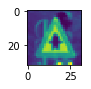

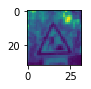

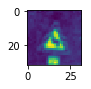

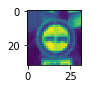

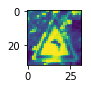

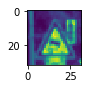

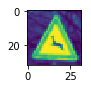

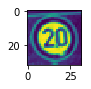

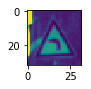

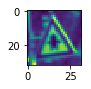

In [7]:
#showing augmented images and its classes
for i in range(10):
    index = np.random.randint(34799, (len(X_train)))
    image = X_train[index].squeeze()
    
    plt.figure(figsize=(1,1))
    plt.imshow(image)
    print(y_train[index])

#data = X_train
#random = np.random.randint(34799,(len(data)))
#plt.imshow(data[random].squeeze(), cmap="gray")
#plt.imshow(X_train)

In [8]:
def histogram_equalization(img_array):
    l,w,h = img_array.shape[1:]
    equalized_images = np.empty((0,l,w,h))
    for i in range(len(img_array)):
        img_yuv = cv2.cvtColor(img_array[i], cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        img_out = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
        img_out = np.reshape(img_out, (1,l,w,h))
        equalized_images = np.append(equalized_images, img_out,axis = 0)
    return equalized_images 

#X_train = histogram_equalization(X_train)

    4. Describe how you set up the training, validation and testing data for your model. Once I have my data preprocess, next splitting the data into 80,20

In [9]:
#shuffle the data afterwards 
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.02, random_state=0)


print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("Y_valid shape", X_validation.shape)

X_train shape (90783, 32, 32, 1)
X_test shape (12630, 32, 32, 1)
Y_valid shape (1853, 32, 32, 1)


What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.) For reference on how to build a deep neural network using TensorFlow, see Deep Neural Network in TensorFlow from the classroom


I am using a 4 layer network :

Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
Activation: relu    
Pooling. Input = 28x28x6. Output = 14x14x6.
Layer 2: Convolutional. Output = 10x10x16.
Activation: relu
Pooling. Input = 10x10x16. Output = 5x5x16.
Flatten. Input = 5x5x16. Output = 400.
Layer 3: Fully Connected. Input = 400. Output = 120.
Activation: relu
Dropout
Layer 4: Fully Connected. Input = 120. Output = 84.
Activation: relu
W4 = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
Dropout
Layer 5: Fully Connected. Input = 84. Output = 43.


    4.How did you train your model?
 about the optimizer used, and some of the hyperparameters (learning rate, keep_prob).


EPOCHS = 10
BATCH_SIZE = 128
MU = 0
SIGMA = 0.1

In [10]:
import tensorflow as tf
EPOCHS = 10
BATCH_SIZE = 128
n_classes = len(np.unique(y_train))

In [11]:
def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    x = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID')
    b1 = tf.Variable(tf.zeros(6))
    x = tf.nn.bias_add(x, b1)
    print("layer 1 shape:",x.get_shape())

    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    x = tf.nn.conv2d(x, W2, strides=[1, 1, 1, 1], padding='VALID')
    b2 = tf.Variable(tf.zeros(16))
    x = tf.nn.bias_add(x, b2)
                     
    # TODO: Activation.
    x = tf.nn.relu(x)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    x = flatten(x)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    W3 = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    b3 = tf.Variable(tf.zeros(120))    
    x = tf.add(tf.matmul(x, W3), b3)
    
    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    W4 = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    b4 = tf.Variable(tf.zeros(84)) 
    x = tf.add(tf.matmul(x, W4), b4)
    
    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    W5 = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    b5 = tf.Variable(tf.zeros(43)) 
    logits = tf.add(tf.matmul(x, W5), b5)
    
    return logits

print('done')

done


In [12]:
x = tf.placeholder(tf.float32, shape=[None,32,32,1])
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)
                   
#Invoke LeNet function by passing features
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)



layer 1 shape: (?, 28, 28, 6)


In [13]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

print('done')

done


In [14]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.859

EPOCH 2 ...
Validation Accuracy = 0.929

EPOCH 3 ...
Validation Accuracy = 0.952

EPOCH 4 ...
Validation Accuracy = 0.969

EPOCH 5 ...
Validation Accuracy = 0.974

EPOCH 6 ...
Validation Accuracy = 0.982

EPOCH 7 ...
Validation Accuracy = 0.987

EPOCH 8 ...
Validation Accuracy = 0.983

EPOCH 9 ...
Validation Accuracy = 0.989

EPOCH 10 ...
Validation Accuracy = 0.992

Model saved


In [15]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./lenet.meta')
    saver2.restore(sess, "./lenet")
    test_accuracy = evaluate(X_test, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))

Test Set Accuracy = 0.928


    5.What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem.

This has been a back and forth challenge where I truly invest my time on data agumentations vs trying other neural network and tuning their parameters. 

This takes me for a few weeks to get to this acceptable accuracy.
Totally a steep learning curve on how does data quality as well as effects on the accuracy.

    6.Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?

Those images are search under German traffic sign and somehow it shouldnt be any harder or confusing than pervious training ones. I thought of using Hong Kong  traffic sign where there is an english and chinese character side by side but turns out it totally doesnt work at all.


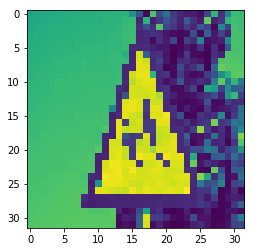

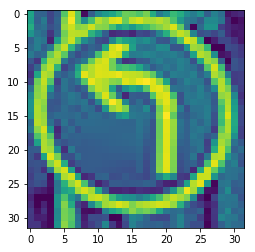

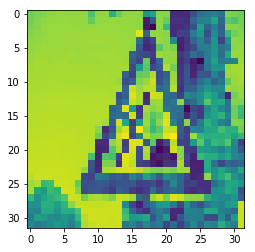

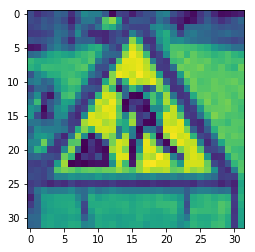

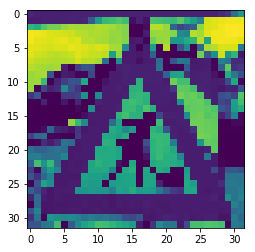

In [16]:
import glob
my_image = np.zeros((5,32,32,1))
for i, img in enumerate(glob.glob('./traffic-signs-data/germansign/image*.jpg')):
    image = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (32, 32))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = (image -128/128)
    my_image[i][:][:][:] =np.array(image)[...,np.newaxis]
    plt.imshow(image)
    plt.show()
    #figures[i] = my_image[i].squeeze()
    #plot_figures(figures)
labels = np.array([28,35,25,25,25], dtype = 'uint8')

In [17]:
my_single_item_array = []
my_single_item_label_array = []

for i in range(5):
    my_single_item_array.append(my_image[i])
    my_single_item_label_array.append(labels[i])

    with tf.Session() as sess2:
        sess2.run(tf.global_variables_initializer())
#         saver = tf.train.import_meta_graph('./lenet.meta')
        saver.restore(sess2, tf.train.latest_checkpoint('.'))
        my_accuracy = evaluate(my_image, labels)
        print('Image {}'.format(i+1))
        print("Image Accuracy = {:.3f}".format(my_accuracy))
        print()

Image 1
Image Accuracy = 0.200

Image 2
Image Accuracy = 0.200

Image 3
Image Accuracy = 0.200

Image 4
Image Accuracy = 0.200

Image 5
Image Accuracy = 0.200



In [19]:
logits = LeNet(x)
softmax = tf.nn.softmax(logits)

sess2 = tf.get_default_session()

with tf.Session() as sess2:
    sess2.run(tf.global_variables_initializer())
    saver.restore(sess2, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(my_image, labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    result = sess2.run(softmax, feed_dict={x: my_image,keep_prob: 1.})
    values, indices = tf.nn.top_k(result, 5)
    
    predictions  = sess2.run(values)
    predictionIndicies  = sess2.run(indices)
    print("softmax probabilties for top 5 predictions are:")
    print(predictions)
    print("predictionIndicies")
    print(predictionIndicies)
    

layer 1 shape: (?, 28, 28, 6)
Test Accuracy = 0.200
softmax probabilties for top 5 predictions are:
[[9.8019731e-01 1.9514663e-02 2.8764521e-04 3.5996936e-07 2.9008936e-11]
 [9.9997079e-01 2.8299393e-05 7.5334242e-07 2.3953129e-07 6.0325378e-12]
 [9.2983109e-01 4.0447645e-02 2.9501962e-02 2.1934680e-04 1.9368204e-13]
 [9.9999654e-01 3.4768188e-06 3.9865968e-09 3.0953955e-11 1.2930123e-13]
 [1.0000000e+00 3.0701548e-13 4.9173519e-14 4.0908581e-18 1.1156416e-20]]
predictionIndicies
[[21 14  1 29 37]
 [37 29 42  1 14]
 [14 21 29  1 37]
 [29  1 21 14 24]
 [ 1 14 29 37 21]]


    Reflection: 
This project has been the most time consuming one where at first I spent the majority time of to tune the neuarl network and the highest I was able to get was around 92.3% validation accuracy with 100% testing and training. 
Next, I need to return on data augmentations that would take me sometimes to figure out and having the mentor helps meanwhile. Once that part was solved, I have to change the preprocess again with a different approach. 
Finally, along the way I am able to get 98.3% accuracy on the validation.

